# Insert Title Here
**DATA102 S11 Group 3*
- Banzon, Beatrice Elaine B.
- Buitre, Cameron
- Marcelo, Andrea Jean C.
- Navarro, Alyssa Riantha R.
- Vicente, Francheska Josefa

# **Requirements and Imports**
Before starting, the relevant libraries and files in building and training the model should be loaded into the notebook first.

## **Basic** Libraries
* `numpy` contains a large collection of mathematical functions
* `pandas` contains functions that are designed for data manipulation and data analysis

In [1]:
import numpy as np
import pandas as pd

## **`Natural Language Processing`** Libraries
* `train_test_split` is a function that allows the dataset to be split into two randomly.
* `TFidfVectorizer` converts the given text documents into a matrix, which has TF-IDF features
* `CountVectorizer` converts the given text documents into a matrix, which has the counts of the tokens

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

## **`Machine Learning`** Libraries
The following classes are models that implement different methods of clustering or classification.
- `KMeans` is a class under the cluster models module that implements k-means clustering.
- `LogisticRegression` is a class under the linear models module that implements regularized logistic regression

In [3]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

Next is the `shuffle` function which shuffles matrices and arrays.

In [4]:
from sklearn.utils import shuffle

On the other hand, these classes computes and visualizes the different scores about how well a model works.
* `f1_score` computes the balanced F-score by comparing the actual classes and the predicted classes
* `hamming_loss` computes the fraction of labels that were incorrectly labeled by the model
* `accuracy_score` computes the accuracy by determining how many classes were correctly predicted
* `precision_recall_fscore_support`computes the precision, recall, F-measure and support per class
* `ConfusionMatrixDisplay` allows the visualization of the computed confusion matrix
* `confusion_matrix`  is a function that displays the number of samples that are correctly and incorrectly labeled by the model, by grouping them into four groups (i.e., True Positives, False Positives, True Negatives, False Negatives)

In [5]:
from sklearn.metrics import f1_score, roc_auc_score, hamming_loss, accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [6]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

Meanwhile, `GridSearchCV` is a cross-validation class that allows the exhaustive search over all possible combinations of hyperparameter values

In [ ]:
from sklearn.model_selection import GridSearchCV

Last, `pickle` is a module that can serialize and deserialize objects. In this notebook, it is used to save and load models.

In [ ]:
import pickle

### Datasets and Files
To train the models that utilizes the traditional machine learning algorithms, the dataset that was cleaned will be loaded using the [`read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function.

In [ ]:
df = pd.read_csv ('cleaned_data.csv')
df

# **Feature Engineering**

As we cannot directly feed the text data as input to the machine learning models, we have to convert it into the format that they can understand—numbers. Before doing that, since we want to save the models and vectorizers that we will be using, we will first need to define the values and functions to do so, starting with the folder where we will be saving it. 

In [ ]:
main_directory = './saved_models/Clustering/vectorizers/'

Next, we will be creating a function that will be saving the vectorizer to the specified path.

In [ ]:
def save_vectorizers (vectorizer, vectorizer_name):
    vectorizer_filename = main_directory + vectorizer_name + '.pkl'
    
    with open(vectorizer_filename, 'wb') as file:
        pickle.dump(vectorizer, file)

## Splitting the Dataset into **`Train`**, **`Validation`**, and **`Test`** Split
Let us first define the **X** (input) and **y** (target/output) of our model. This is done to allow the stratifying of the data when it is split into the train, val and test.

The **X** (input) can be retrieved by getting the `text` column in the original dataset.

In [ ]:
X = df ['text']
X

Meanwhile, the **y** value (i.e., the value that we would be "feeding" our models) is the `label` column. 

In [ ]:
y = df ['label']
y

Now that we have declared the input and the target output of our models, we can use the [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to divide the dataset into two splits. Some things to note are: (1) the split is stratified based on the **y values**, (2) the value of the random state was set to 42 for reproducibility, and (3) the dataset is shuffled.

First, let us create the train and test set. The test set is made up of 20% of the original dataset, which infers that the second split is 80% of the original. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 42, 
                                                    shuffle = True)

Second, we will be splitting the remaining 80% of the original dataset into two: the train and val sets. The train set will be 90% of the second split, while the val set will be 10% of it. 

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size = 0.1,
                                                  stratify = y_train,
                                                  random_state = 42, 
                                                  shuffle = True)

However, since we want to test if deciding the `class` of the prediction based on the dominant class of the points in a cluster is enough, we want to make sure that the train dataset has equal number of instances for each of the class.  To do this, we created a function that would ensure that the number of positive and negative instances are equal.

In [ ]:
def make_dataframe (df):
    true_df = df [df ['label'] == 1][['text', 'label']]
    false_df = df [df ['label'] == 0][['text', 'label']]
    
    num_of_true = len(true_df)
    
    false_df = false_df.sample(n = num_of_true)
    false_df = false_df.reset_index(drop=True)
    
    df = false_df.append(true_df, ignore_index = True)
    df = shuffle(df.reset_index(drop=True)).reset_index(drop=True)
    
    return df

To easily divide the train set, let us first [`concat`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html)enate the X_train and y_train into one DataFrame. In addition to this, to ensure that the index of the DataFrame is sequential, we would be using the [`reset_index`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html) function. 

In [ ]:
train_df = pd.concat([X_train, y_train], axis = 1).reset_index(drop = True)
train_df

Using the combined DataFrame, we would be creating a DataFrame that has equal number of positive and negative instances.

In [ ]:
train_df = make_dataframe (train_df)
train_df

As we have changed the train dataset, we would be re-declaring the values for the X and y of the train dataset.

In [ ]:
X_train = train_df ['text']
y_train = train_df ['label']

For consistency, we would also be [`concat`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html)enating the validation set.

In [ ]:
val_df = pd.concat([X_val, y_val], axis = 1).reset_index(drop = True)
val_df

And lastly, the test set would also be [`concat`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html)enated into one DataFrame.

In [ ]:
test_df = pd.concat([X_test, y_test], axis = 1).reset_index(drop = True)
test_df

To check if the shapes of the input and output are the same, we will be looking at the shapes of the resulting DataFrame.


In [ ]:
print('Train')
print('Input  shape: ', X_train.shape)
print('Output shape: ', y_train.shape, '\n')

print('Val')
print('Input  shape: ', X_val.shape)
print('Output shape: ', y_val.shape, '\n')

print('Test')
print('Input  shape: ', X_test.shape)
print('Output shape: ', y_test.shape, '\n') 

## Tokenizing with **`TF-IDF` Vectorizer**

Now, we can proceed with tokenizing our input. To do this, we first create an instance of a [`TF-IDF Vectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) with english stopwords as its list of stopwords and a maximum feature of 5000.

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 5000)

### **`Train`** Data
With the created vectorizer, we can now use the [`fit_transform`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.fit_transform) function, which will learn the vocabulary and the inverse document frequency from the data provided, and then create a document-term matrix using the same data.

In [ ]:
tfidf_train = tfidf_vectorizer.fit_transform(X_train.values.astype('U'))

To use this vectorizer that has learned from the vocabulary, let us save it using the function we previously defined. 

In [ ]:
save_vectorizers(tfidf_vectorizer, 'tfidf')

### **`Validation`** Data
Using the [`transform`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.transform) function, we will be creating a document-term matrix for the validation set. For this, it is important to convert the datatype of the values in the validation set into **Unicode**, as this is the type accepted by the function.

In [ ]:
tfidf_val = tfidf_vectorizer.transform(X_val.values.astype('U'))

### **`Test`** Data
Next, we will also [`transform`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.transform) our test data into a document-term matrix, and to do this, we also have to convert it into the **Unicode** datatype.

In [ ]:
tfidf_test = tfidf_vectorizer.transform(X_test.values.astype('U'))

## Tokenizing with **`Count` Vectorizer**

We create a [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) object, with the same parameter values as the [`TF-IDF Vectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

In [ ]:
count_vectorizer = CountVectorizer(stop_words = 'english', max_features = 5000)

In [ ]:
count_train = count_vectorizer.fit_transform(X_train.values.astype('U'))
save_vectorizers(count_vectorizer, 'count')

In [ ]:
count_val = count_vectorizer.transform(X_val.values.astype('U'))

In [ ]:
count_test = count_vectorizer.transform(X_test.values.astype('U'))

# Modeling and Evaluation
Now that we have transformed our data into the format that our algorithms can understand, we can move on to the modeling proper.

## Defining the **Functions**
To start with, let us first define the functions and the values needed to easily train the model. First, we would be creating a function that would convert the cluster number of the points into a prediction of 0 or 1 (i.e,. news or fake news). 

In [ ]:
def convert_to_label (prediction, labels_per_cluster):
    return labels_per_cluster [prediction]

Next, we will be creating a function that will call the functions for the metrics (i.e., [`accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html), [`f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), [`hamming_loss`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hamming_loss.html), and [`precision_recall_fscore_support`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)) that are used for the scoring. 

In [ ]:
def scores (y_true, y_pred):
    accuracy = accuracy_score(y_true = y_true, y_pred = y_pred)   
    f1_micro_average = f1_score(y_true = y_true, y_pred = y_pred, average = 'micro')
    f1_macro_average = f1_score(y_true = y_true, y_pred = y_pred, average = 'macro')
    hamming_loss_score = hamming_loss(y_true = y_true, y_pred = y_pred)
    precision, recall, _, _ = precision_recall_fscore_support(y_true, y_pred, average = 'weighted')
    
    return accuracy, f1_micro_average, f1_macro_average, hamming_loss_score, precision, recall

To be able to view the scores in a readable format, we also created a function that would create a dictionary out of the scores.

In [ ]:
def format_scores (k, y_true, y_pred):
    accuracy, f1_micro_average, f1_macro_average, hamming_loss_score, precision, recall = scores (y_true, y_pred)
    
    return {
        'K' : k,
        'Accuracy' : accuracy,
        'F1 Micro Average' : f1_micro_average,
        'F1 Macro Average' : f1_macro_average,
        'Hamming Loss' : hamming_loss_score,
        'Precision' : precision,
        'Recall' : recall,
    }

Next, since we would be experimenting on two ways to predict using clusters (i.e., predicting by looking at the dominant class per cluster, and using the cluster number as additional information in a Logistic Regresion model), we would be defining functions that could do the clustering and prediction in these two ways.

The `cluster_categorize_predict` is the function that would be used for the latter process. In this function, there are four major steps: (1) the points are clustered by the trained K-means clustering model, (2) the predictions are appended to the dataset, (3) the Logistic Regression model was used to predict the resulting DataFrame (i.e., the one where the clusters were appended into), and (4) the score of the model was computed.

In [ ]:
def cluster_categorize_predict (k, orig_df, df_set, km, model, vectorizer):
    predictions = km.predict (df_set)
    converted_df = pd.DataFrame(df_set.toarray(), columns = vectorizer.get_feature_names_out())
    
    labeled_df = orig_df.copy() 
    labeled_df ['predictions'] = predictions 
    
    temp_x = pd.concat ([converted_df, labeled_df ['predictions']], axis = 1)
    
    predictions = model.predict (temp_x.values)
    
    dict_scores = format_scores (k, labeled_df ['label'], val_predictions)
    
    return dict_scores

Then, the `cluster_then_categorize_news` function is used to: (1) train the model that is used for k-means clustering, (2) predict on the train data using the k-means, (3) concatenate the cluster result of the k-means model to the vectorized matrix, (4) train the Logistic Regression model using the resulting matrix, and (5) predict on the test set by calling `cluster_categorize_predict`.

In [ ]:
def cluster_then_categorize_news (k, train_set, val_set, model, vectorizer):
    label_per_cluster = {}
    
    km = KMeans (n_clusters = k, random_state = 42)
    km.fit (train_set)
    train_predictions = km.predict (train_set)
    converted_train = pd.DataFrame(train_set.toarray(), columns = vectorizer.get_feature_names_out())
    
    train_labeled_df = train_df.copy() 
    train_labeled_df ['predictions'] = train_predictions
    
    temp_x_train = pd.concat ([converted_train, train_labeled_df ['predictions']], axis = 1)

    model.fit (temp_x_train.values, y_train)

    dict_scores = cluster_categorize_predict (k, val_df, val_set, km, model, vectorizer)
        
    return dict_scores, km, model

Last, the `cluster_news` function is used for the former process of predicting using the cluster. In this, instead of using the cluster number as an additional feature for the Logistic Regression model, it just converts the cluster number to the dominant class per cluster. 

In [ ]:
def cluster_news (k, train_set, val_set):
    label_per_cluster = {}
    
    km = KMeans (n_clusters = k, random_state = 42)
    km.fit (train_set)
    train_predictions = km.predict (train_set)
    train_labeled_df = train_df.copy() 
    train_labeled_df ['predictions'] = train_predictions

    for i in range (k + 1):
        dominant_label = train_labeled_df.groupby ('predictions')[['label']].value_counts().index [i][1]
        label_per_cluster [i] = dominant_label
    
    train_labeled_df ['predictions'] = train_labeled_df ['predictions'].replace(labels_per_cluster)

    dict_scores = format_scores (k, train_labeled_df ['label'], train_labeled_df ['predictions'])

    val_predictions = km.predict (val_set)
    val_labeled_df = val_df.copy() 
    val_labeled_df ['predictions'] = val_predictions 
    val_labeled_df ['predictions'] = val_labeled_df ['predictions'].replace(labels_per_cluster)

    dict_scores = format_scores (k, val_labeled_df ['label'], val_labeled_df ['predictions'])
        
    return dict_scores, km, label_per_cluster

## K-means (TF-IDF Vectorizer)
With all of the relevant functions declared, we can now proceed with the actual training proper.

For the first model, we would be using the resulting matrix from the [`TF-IDF Vectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to train the k-means model. The resulting clusters would determine the class of the text by getting the dominant class in a cluster.

To do this, we will first declare a dictionary that would hold the dominant class per cluster number.

In [ ]:
labels_per_cluster = {}

To be able to find the best k-value for the model, we would be creating a list that would hold the scores of the each of the value of the k.

In [ ]:
tfidf_val_scores = []

In addition to the scores, we would have to create a list of k-means model and the list of dictionaries that would allow us to use the best model for prediction.

In [ ]:
tfidf_models = []
tfidf_labels_per_cluster = []

With these, we can start training k-means clustering models with different k valuesusing the `cluster_news` function. This would allow us to determine which k-value would result in the highest validation score. 

In [ ]:
for k in range (1, 60):
    val_score, model, label = cluster_news (k, tfidf_train, tfidf_val)
    tfidf_val_scores.append (val_score)
    tfidf_models.append (model)
    tfidf_labels_per_cluster.append (label)

With the training of the models finished, we can now look at the DataFrame of their validation scores. Using the [`sort_values`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html) function, we would be sorting the scores of the model by the **Recall**.

In [ ]:
scores_df = pd.DataFrame (tfidf_val_scores)
scores_df = scores_df.sort_values ('F1 Macro Average', ascending = False)
scores_df

In [ ]:
best_model_index = int (scores_df.loc [0]['K']) - 1

In [ ]:
val_predictions = tfidf_models [best_model_index].predict (tfidf_val)
val_labeled_df = val_df.copy() 
val_labeled_df ['predictions'] = val_predictions 
val_labeled_df ['predictions'] = val_labeled_df ['predictions'].replace(tfidf_labels_per_cluster [best_model_index])

In [ ]:
dict_scores = format_scores (best_model_index + 1, val_labeled_df ['label'], val_labeled_df ['predictions'])
dict_scores

In [ ]:
test_predictions = tfidf_models [best_model_index].predict (tfidf_test)
test_labeled_df = test_df.copy() 
test_labeled_df ['predictions'] = test_predictions 
test_labeled_df ['predictions'] = test_labeled_df ['predictions'].replace(tfidf_labels_per_cluster [best_model_index])

In [ ]:
dict_scores = format_scores (best_model_index - 1, test_labeled_df ['label'], test_labeled_df ['predictions'])
dict_scores

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(test_labeled_df ['label'], test_labeled_df ['predictions'])).plot()

## K-means (Count Vectorizer)

In [46]:
count_val_scores = []
count_models = []
count_labels_per_cluster = []

In [47]:
for k in range (1, 60):
    val_score, model, label = cluster_news (k, count_train, count_val)
    count_val_scores.append (val_score)
    count_models.append (model)
    count_labels_per_cluster.append (label)

C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_km

C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:

C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:

C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:

C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:

C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:

C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:

In [48]:
scores_df = pd.DataFrame (count_val_scores)
scores_df.sort_values ('Recall', ascending = False)

,K,Accuracy,F1 Micro Average,F1 Macro Average,Hamming Loss,Precision,Recall
0,1,0.802269,0.802269,0.445144,0.197731,0.643636,0.802269
1,2,0.718531,0.718531,0.562240,0.281469,0.722266,0.718531
3,4,0.678012,0.678012,0.367040,0.321988,0.728120,0.678012
10,11,0.588871,0.588871,0.151680,0.411129,0.726549,0.588871
9,10,0.573204,0.573204,0.136907,0.426796,0.717389,0.573204
30,31,0.320367,0.320367,0.038904,0.679633,0.700796,0.320367
17,18,0.243112,0.243112,0.061993,0.756888,0.842545,0.243112
6,7,0.172880,0.172880,0.079071,0.827120,0.606959,0.172880
20,21,0.139384,0.139384,0.024917,0.860616,0.794527,0.139384
12,13,0.121556,0.121556,0.039764,0.878444,0.653498,0.121556


In [49]:
val_predictions = count_models [1].predict (count_val)
val_labeled_df = val_df.copy() 
val_labeled_df ['predictions'] = val_predictions 
val_labeled_df ['predictions'] = val_labeled_df ['predictions'].replace(count_val_scores [1])

In [50]:
dict_scores = format_scores (2, val_labeled_df ['label'], val_labeled_df ['predictions'])
dict_scores

{'K': 2,
 'Accuracy': 0.7185305240410589,
 'F1 Micro Average': 0.7185305240410589,
 'F1 Macro Average': 0.5622395271826833,
 'Hamming Loss': 0.2814694759589411,
 'Precision': 0.7222663991485183,
 'Recall': 0.7185305240410589}

In [51]:
test_predictions = count_models [1].predict (count_test)
test_labeled_df = test_df.copy() 
test_labeled_df ['predictions'] = test_predictions 
test_labeled_df ['predictions'] = test_labeled_df ['predictions'].replace(count_labels_per_cluster [1])

In [52]:
dict_scores = format_scores (2, test_labeled_df ['label'], test_labeled_df ['predictions'])
dict_scores

{'K': 2,
 'Accuracy': 0.7279014480224768,
 'F1 Micro Average': 0.7279014480224768,
 'F1 Macro Average': 0.5656434064829965,
 'Hamming Loss': 0.27209855197752325,
 'Precision': 0.7241807889524337,
 'Recall': 0.7279014480224768}

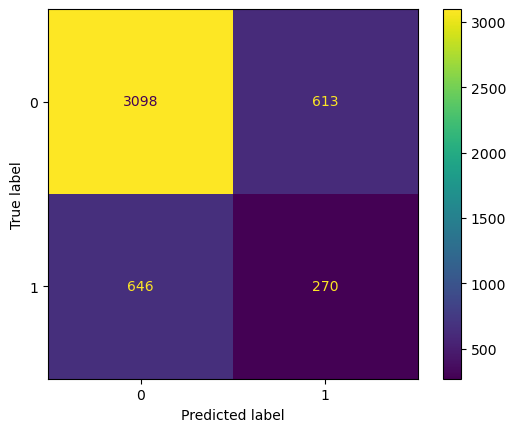

In [53]:
ConfusionMatrixDisplay(confusion_matrix(test_labeled_df ['label'], test_labeled_df ['predictions'])).plot()

## K-means and Logistic Regression (TF-IDF Vectorizer)

In [94]:
tfidf_logreg_models = []
tfidf_logreg_km_models = []
tfidf_logreg_scores = []

In [95]:
for k in range (1, 60):
    logreg_model = LogisticRegression ()
    val_score, km, model = cluster_then_categorize_news (k, count_train, count_val, logreg_model, tfidf_vectorizer)
    tfidf_logreg_scores.append (val_score)
    tfidf_logreg_models.append (model)
    tfidf_logreg_km_models.append (km)

C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase th

C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase th

C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase th

C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\admin\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase th

In [96]:
tfidf_logreg_scores

[{'K': 1,
  'Accuracy': 0.7185305240410589,
  'F1 Micro Average': 0.7185305240410589,
  'F1 Macro Average': 0.5622395271826833,
  'Hamming Loss': 0.2814694759589411,
  'Precision': 0.7222663991485183,
  'Recall': 0.7185305240410589},
 {'K': 2,
  'Accuracy': 0.7185305240410589,
  'F1 Micro Average': 0.7185305240410589,
  'F1 Macro Average': 0.5622395271826833,
  'Hamming Loss': 0.2814694759589411,
  'Precision': 0.7222663991485183,
  'Recall': 0.7185305240410589},
 {'K': 3,
  'Accuracy': 0.7185305240410589,
  'F1 Micro Average': 0.7185305240410589,
  'F1 Macro Average': 0.5622395271826833,
  'Hamming Loss': 0.2814694759589411,
  'Precision': 0.7222663991485183,
  'Recall': 0.7185305240410589},
 {'K': 4,
  'Accuracy': 0.7185305240410589,
  'F1 Micro Average': 0.7185305240410589,
  'F1 Macro Average': 0.5622395271826833,
  'Hamming Loss': 0.2814694759589411,
  'Precision': 0.7222663991485183,
  'Recall': 0.7185305240410589},
 {'K': 5,
  'Accuracy': 0.7185305240410589,
  'F1 Micro Average'

In [97]:
scores_df = pd.DataFrame (tfidf_logreg_scores)
scores_df.sort_values ('Recall', ascending = False)

,K,Accuracy,F1 Micro Average,F1 Macro Average,Hamming Loss,Precision,Recall
0,1,0.718531,0.718531,0.56224,0.281469,0.722266,0.718531
44,45,0.718531,0.718531,0.56224,0.281469,0.722266,0.718531
32,33,0.718531,0.718531,0.56224,0.281469,0.722266,0.718531
33,34,0.718531,0.718531,0.56224,0.281469,0.722266,0.718531
34,35,0.718531,0.718531,0.56224,0.281469,0.722266,0.718531
35,36,0.718531,0.718531,0.56224,0.281469,0.722266,0.718531
36,37,0.718531,0.718531,0.56224,0.281469,0.722266,0.718531
37,38,0.718531,0.718531,0.56224,0.281469,0.722266,0.718531
38,39,0.718531,0.718531,0.56224,0.281469,0.722266,0.718531
39,40,0.718531,0.718531,0.56224,0.281469,0.722266,0.718531


In [ ]:
test_predictions = tfidf_logreg_models [1].predict (count_test)
test_labeled_df = test_df.copy() 
test_labeled_df ['predictions'] = test_predictions 
test_labeled_df ['predictions'] = test_labeled_df ['predictions'].replace(count_labels_per_cluster [1])

In [ ]:
dict_scores = format_scores (2, test_labeled_df ['label'], test_labeled_df ['predictions'])
dict_scores

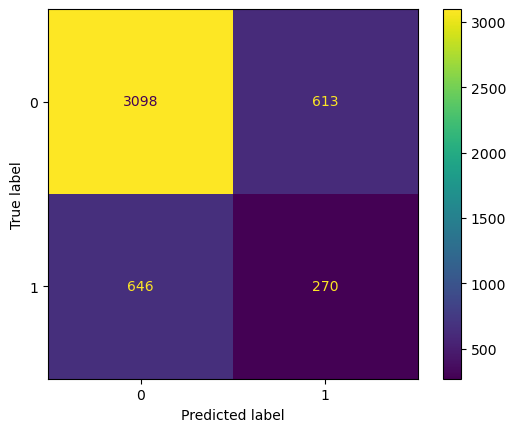

In [79]:
ConfusionMatrixDisplay(confusion_matrix(test_labeled_df ['label'], test_labeled_df ['predictions'])).plot()